# INFO6105: Data Science Engineering Methods

#Assignment 3: Model Interpretability


The aim is to acheive the below:

1. Fit a linear model and interpret the regression coefficients

2. Fit a tree-based model and interpret the nodes

3.  Use auto ml to find the best model

4. Run SHAP analysis on the models from steps 1, 2, and 3,   interpret the SHAP values and compare them with the other model interpretability methods.

#Abstract

The Dataset: https://www.kaggle.com/datasets/houcembenmansour/predict-diabetes-based-on-diagnostic-measures

The goal of this study is to develop a machine learning model to accurately predict the presence of diabetes in patients, utilizing a dataset sourced from the National Institute of Diabetes and Digestive and Kidney Diseases. This dataset includes a series of medical predictor variables alongside a target variable, diabetes, enabling the diagnostic prediction of the disease's presence. The predictor variables encompass a range of diagnostic measurements such as the number of pregnancies, body mass index (BMI), weight, age, and glucose levels among others. The primary challenge lies in identifying the most influential predictors for diabetes presence and leveraging them to construct a predictive model. By employing feature selection techniques, the study aims to pinpoint these key predictors and subsequently apply a suitable machine learning technique, possibly logistic regression, to develop a robust model for diabetes prediction. This approach endeavors to enhance the accuracy of diabetes diagnosis, contributing significantly to the field of medical diagnostics and patient care.

#Installing Dependencies

In [144]:
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future

In [145]:
#h2o install

!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html


In [146]:
#Importing all required libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn import tree
from sklearn import linear_model
from sklearn import ensemble
import statsmodels.api as sd
import sklearn.metrics as sm
from sklearn.model_selection import train_test_split
import random

import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings("ignore")

# importing shap
!pip install shap
import shap

import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(context="notebook", palette="Spectral", style = 'darkgrid' ,font_scale = 1.5, color_codes=True)
import warnings
warnings.filterwarnings('ignore')
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
from sklearn.model_selection import train_test_split as tts
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from yellowbrick.regressor import ResidualsPlot
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

# Loading the Dataset and Exploring

Now that we have installed the H2O package, we can proceed with loading the dataset into the H2O environment before performing the necessary data analysis and modeling.

In [147]:
# Reading the CSV file into a Pandas DataFrame, replacing commas with periods for decimal points
df_train = pd.read_csv("https://raw.githubusercontent.com/ronakmishra619/Data_Science_Assignment/main/diabetes.csv", decimal=",")



In [148]:
df_train.head()

,patient_number,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,diabetes
0,1,193,77,49,3.9,19,female,61,119,22.5,118,70,32,38,0.84,No diabetes
1,2,146,79,41,3.6,19,female,60,135,26.4,108,58,33,40,0.83,No diabetes
2,3,217,75,54,4.0,20,female,67,187,29.3,110,72,40,45,0.89,No diabetes
3,4,226,97,70,3.2,20,female,64,114,19.6,122,64,31,39,0.79,No diabetes
4,5,164,91,67,2.4,20,female,70,141,20.2,122,86,32,39,0.82,No diabetes


#Finding the types of data

In [149]:
#finding the columns and types of data in the dataset
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390 entries, 0 to 389
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   patient_number   390 non-null    int64  
 1   cholesterol      390 non-null    int64  
 2   glucose          390 non-null    int64  
 3   hdl_chol         390 non-null    int64  
 4   chol_hdl_ratio   390 non-null    float64
 5   age              390 non-null    int64  
 6   gender           390 non-null    object 
 7   height           390 non-null    int64  
 8   weight           390 non-null    int64  
 9   bmi              390 non-null    float64
 10  systolic_bp      390 non-null    int64  
 11  diastolic_bp     390 non-null    int64  
 12  waist            390 non-null    int64  
 13  hip              390 non-null    int64  
 14  waist_hip_ratio  390 non-null    float64
 15  diabetes         390 non-null    object 
dtypes: float64(3), int64(11), object(2)
memory usage: 48.9+ KB


In [150]:
# Dropping specified columns
df_train = df_train.drop(['patient_number', 'height', 'weight', 'waist', 'hip'], axis=1)

# Display the first few rows of the modified DataFrame to verify the changes
print(df_train.head())

   cholesterol  glucose  hdl_chol  chol_hdl_ratio  age  gender   bmi  \
0          193       77        49             3.9   19  female  22.5   
1          146       79        41             3.6   19  female  26.4   
2          217       75        54             4.0   20  female  29.3   
3          226       97        70             3.2   20  female  19.6   
4          164       91        67             2.4   20  female  20.2   

   systolic_bp  diastolic_bp  waist_hip_ratio     diabetes  
0          118            70             0.84  No diabetes  
1          108            58             0.83  No diabetes  
2          110            72             0.89  No diabetes  
3          122            64             0.79  No diabetes  
4          122            86             0.82  No diabetes  


**Observation**

Here I observed that the DataFrame df_train has been modified to remove the columns patient_number, height, weight, waist, and hip. The displayed output showcases the first few rows of the updated DataFrame, which now includes columns such as cholesterol, glucose, hdl_chol, chol_hdl_ratio, age, gender, bmi, systolic_bp, diastolic_bp, waist_hip_ratio, and diabetes. The modification aims to focus the analysis on these remaining features, potentially for a study related to health metrics and their association with diabetes.

**Data Preprocessing: Encoding Categorical Variables**

In [151]:
df_train.gender = pandas_df.gender.replace({"female": 0, "male": 1})  # female = 0, male = 1
df_train.diabetes = pandas_df.diabetes.replace({"No diabetes": 0, "Diabetes": 1})  # no diabetes = 0, diabetes = 1
df_train.head()

,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,bmi,systolic_bp,diastolic_bp,waist_hip_ratio,diabetes
0,193,77,49,3.9,19,0,22.5,118,70,0.84,0
1,146,79,41,3.6,19,0,26.4,108,58,0.83,0
2,217,75,54,4.0,20,0,29.3,110,72,0.89,0
3,226,97,70,3.2,20,0,19.6,122,64,0.79,0
4,164,91,67,2.4,20,0,20.2,122,86,0.82,0


**Observation**

Here, the code is converting categorical columns 'gender' and 'diabetes' in the DataFrame df_train into numeric formats for model interpretability or preparation. Specifically, it changes 'female' to 0 and 'male' to 1 in the 'gender' column, and 'No diabetes' to 0 and 'Diabetes' to 1 in the 'diabetes' column. This process is essential for machine learning models that require numerical input.

In [152]:

y_total=df_train['diabetes']
df_train=df_train.drop(['diabetes'],axis=1)

# response and predictors


num_cols=list(df_train._get_numeric_data().columns)
cat_cols=list(set(df_train.columns)-set(num_cols))
df_train.head()

#Storing Numerical and Categorical columns seperately

,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,bmi,systolic_bp,diastolic_bp,waist_hip_ratio
0,193,77,49,3.9,19,0,22.5,118,70,0.84
1,146,79,41,3.6,19,0,26.4,108,58,0.83
2,217,75,54,4.0,20,0,29.3,110,72,0.89
3,226,97,70,3.2,20,0,19.6,122,64,0.79
4,164,91,67,2.4,20,0,20.2,122,86,0.82


**Observation**

Here, I observed that the code is preparing the data for modeling by separating the target variable ('diabetes') from the predictors. It does this by creating y_total, which stores the 'diabetes' column's values, and then removes the 'diabetes' column from df_train. Furthermore, it identifies and separates numerical and categorical columns into num_cols and cat_cols lists, respectively. This separation is crucial for preprocessing steps that may need to treat numerical and categorical data differently, such as normalization or one-hot encoding

In [153]:
#categorical variable encoding using a mapping dictionary as part of preprocessing data
mapping_dict={}
for col in cat_cols:
    mapping_dict[col]={k: i for i, k in enumerate(df_train[col].unique())}
    df_train[col] = df_train[col].map(mapping_dict[col])


In [154]:
df_train.head()

,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,bmi,systolic_bp,diastolic_bp,waist_hip_ratio
0,193,77,49,3.9,19,0,22.5,118,70,0.84
1,146,79,41,3.6,19,0,26.4,108,58,0.83
2,217,75,54,4.0,20,0,29.3,110,72,0.89
3,226,97,70,3.2,20,0,19.6,122,64,0.79
4,164,91,67,2.4,20,0,20.2,122,86,0.82


**Observation**


Here, I observed that the code is encoding categorical variables in df_train using a mapping dictionary. For each categorical column, it creates a unique mapping of category names to integers, starting from 0. This mapping is stored in mapping_dict, where each key is a column name and its value is a dictionary mapping the original category names to integers. Then, it applies this mapping to the DataFrame, effectively converting categorical text data into numerical format. This step is essential for machine learning algorithms that require numerical input, allowing them to interpret and learn from categorical data.

In [155]:
# Normalizing as part of preprocessing

# normalizing numerical columns
num_cols=['age']

from sklearn import preprocessing
feature_to_scale = num_cols

# normalizing using minmax
min_max_scaler = preprocessing.MinMaxScaler()

# Transform the data to fit minmax processor
df_train[feature_to_scale] = min_max_scaler.fit_transform(df_train[feature_to_scale])

df_train.head()




,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,bmi,systolic_bp,diastolic_bp,waist_hip_ratio
0,193,77,49,3.9,0.000000,0,22.5,118,70,0.84
1,146,79,41,3.6,0.000000,0,26.4,108,58,0.83
2,217,75,54,4.0,0.013699,0,29.3,110,72,0.89
3,226,97,70,3.2,0.013699,0,19.6,122,64,0.79
4,164,91,67,2.4,0.013699,0,20.2,122,86,0.82


**Observation**

Here, I observed that the code is performing normalization on the numerical columns specified in the num_cols list, which, in this case, only includes 'age'. It utilizes the MinMaxScaler from sklearn.preprocessing to scale the 'age' column to a range between 0 and 1. This is achieved by fitting the scaler to the 'age' data and then transforming it, effectively normalizing these values. Normalization is a crucial preprocessing step in many machine learning workflows, as it ensures that numerical features contribute equally to the model's training process, preventing features with larger scales from dominating the learning algorithm.

#Fitting a linear model and interpreting the coefficients:

In [156]:
import statsmodels.api as sd
train_X, val_X, train_y, val_y = train_test_split(df_train, y_total, random_state=1)
log_reg = sd.Logit(train_y,train_X).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.193865
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:               diabetes   No. Observations:                  292
Model:                          Logit   Df Residuals:                      282
Method:                           MLE   Df Model:                            9
Date:                Sun, 17 Mar 2024   Pseudo R-squ.:                  0.5222
Time:                        20:43:33   Log-Likelihood:                -56.609
converged:                       True   LL-Null:                       -118.47
Covariance Type:            nonrobust   LLR p-value:                 2.314e-22
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
cholesterol         0.0186      0.010      1.836      0.066      -0.001       0.038
glucose       

**Observation**


Here, I observed the output of fitting a logistic regression model using the Logit function from statsmodels.api. The model aims to predict the binary outcome 'diabetes' based on various predictors like cholesterol levels, glucose levels, and age, among others. The summary output provides several key pieces of information:

Model Performance: The log-likelihood of the model is -56.609, and it has a pseudo R-squared of 0.5222, indicating a moderate fit to the data.
Coefficients: Each predictor's coefficient indicates its impact on the likelihood of diabetes. For example, glucose has a positive coefficient of 0.0461 with a p-value less than 0.001, suggesting a significant positive association with diabetes.

Statistical Significance: P>|z| column shows the p-values for testing the null hypothesis that each coefficient is zero. Coefficients for glucose, waist_hip_ratio are statistically significant (p < 0.05), indicating strong evidence against the null hypothesis for these predictors.

Confidence Intervals: The 95% confidence intervals for the coefficients suggest the range of values within which the true coefficient value is likely to fall. For instance, the interval for glucose ([0.030, 0.062]) does not include 0, further confirming its significance.

The coefficient for waist_hip_ratio is notably significant and negative (-9.1172), indicating that as the waist-hip ratio decreases, the likelihood of diabetes decreases, holding all other factors constant. However, variables like gender and diastolic blood pressure have high p-values, suggesting they are not statistically significant predictors of diabetes in this model.

In [157]:
#Linear Regression model for dataset
def linear_reg(X_train,y_train,val_X,val_y):
    linear_reg = LinearRegression()
    linear_reg_model = linear_reg.fit(train_X,train_y)
    print('Train set')
    pred=linear_reg_model.predict(train_X)
    print('Linear Regression Mean Squared error :{}'.format(mean_squared_error(train_y,pred)))
    print('Linear Regression r2_score :{}'.format(r2_score(train_y,pred)))
    print('Test set')
    pred=linear_reg_model.predict(val_X)
    model_lr=linear_reg_model.predict(val_X)
    print('Linear Regression Mean Squared error :{}'.format(mean_squared_error(val_y,pred)))
    print('Linear Regression r2_score :{}'.format(r2_score(val_y,pred)))

Here, the code fits a linear regression model to the training data, evaluates it on both the training and test datasets, and calculates the Mean Squared Error (MSE) and R² score for each. The MSE assesses the model's accuracy by measuring the average squared difference between the predicted and actual values, while the R² score evaluates the model's explanatory power, indicating how well the independent variables predict the dependent variable. This process is crucial for understanding the model's performance and effectiveness in making predictions.








In [158]:
from sklearn import linear_model

model = linear_model.LinearRegression()
model.fit(train_X, train_y)

LinearRegression()


Here, the code imports the LinearRegression class from sklearn.linear_model and then creates and fits a linear regression model to the training data (train_X and train_y). This process involves determining the best-fit line that minimizes the sum of the squared differences between the observed actual outcomes in the dataset and the outcomes predicted by the linear model. The fitting process calculates the model coefficients (including the intercept and slope) that best predict the dependent variable (train_y) from the independent variables (train_X). This model can then be used to make predictions on new data.

In [159]:
cols1 = ['cholesterol', 'glucose', 'hdl_chol', 'chol_hdl_ratio', 'age', 'gender', 'bmi', 'systolic_bp', 'diastolic_bp', 'waist_hip_ratio']


In [160]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
#Computing R2 for testing and training data
linear_reg(train_X[cols1],train_y,val_X[cols1],val_y)

Train set
Linear Regression Mean Squared error :0.0575117030787114
Linear Regression r2_score :0.5234984111064764
Test set
Linear Regression Mean Squared error :0.0928911218697767
Linear Regression r2_score :0.4056453468105693


**Observation**

Here, the code invokes a predefined function linear_reg, presumably designed to train a linear regression model and evaluate its performance, using specified columns (cols1) from the training and validation datasets. It also prints the Mean Squared Error (MSE) and R² score for both training and test sets.

The output indicates that the model has an MSE of approximately 0.0575 and an R² score of around 0.5235 on the training set. This suggests the model explains over 52% of the variance in the training dataset. On the test set, the MSE increases to about 0.0929, and the R² score decreases to approximately 0.4056, indicating the model explains about 40% of the variance. The higher MSE and lower R² on the test set suggest the model may not generalize as well to unseen data, indicating a potential overfitting to the training data or the model's limitations in capturing the complexity of the data.

#SHAP values for Logistic regression::

In [161]:
# Giving input as 1% of whole dataset as SHAP cant handle large dataset
X = train_X.sample(frac=0.01,random_state=200)
clf_model = LogisticRegression(random_state=0).fit(train_X, train_y)
#LinearExplainer is used as linear regression model is used
explainer = shap.LinearExplainer(clf_model, train_X, feature_perturbation="interventional")
shap_values = explainer.shap_values(val_X) #Saving SHAP values

**Observation**


Here, the code snippet is focused on calculating SHAP (SHapley Additive exPlanations) values for a logistic regression model to interpret its predictions. SHAP values provide insights into how each feature contributes to each prediction, offering a way to understand the model's decision-making process on a per-prediction basis.

A subset of the training data (train_X) is sampled at 1% to serve as an input for the SHAP explainer. This step is necessary because computing SHAP values can be computationally expensive for large datasets.
A logistic regression model (clf_model) is fitted to the entire training dataset (train_X, train_y).
A LinearExplainer from the SHAP library is used, suitable for linear models like logistic regression. The explainer is initialized with the logistic regression model and the training data. The feature_perturbation="interventional" parameter indicates that the SHAP values should be computed based on the assumption that features can be intervened upon independently.
SHAP values for the validation dataset (val_X) are computed using the explainer. These values can then be analyzed to understand the impact of each feature on the model's predictions.
The SHAP values reveal the direction and magnitude of each feature's effect on the model output, providing a powerful tool for interpreting complex model behaviors in a more intuitive and human-understandable form.

#SHAP Analysis for a single point

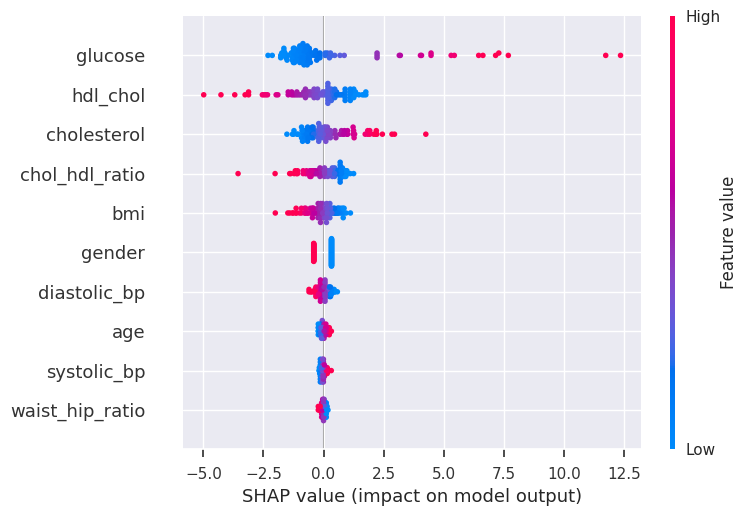

In [162]:
shap.summary_plot(shap_values, val_X, feature_names=list(train_X.columns))

**Observation**


The SHAP summary plot visualizes the impact of each feature on the model's prediction for the validation set. The plot is a beeswarm plot that shows the distribution of the SHAP values for each feature. Here's a brief observation based on the plot:

`Waist-hip ratio`: This feature has the most substantial impact on the model output. Higher values of the waist-hip ratio tend to increase the model's output, while lower values decrease it.

`Systolic blood pressure`: Systolic BP shows a mix of positive and negative impacts on the model output, with a cluster of higher SHAP values indicating a larger positive effect on the model's prediction of diabetes risk.
Glucose: Higher glucose levels appear to significantly increase the risk prediction, as indicated by a cluster of positive SHAP values.

`HDL Cholesterol (hdl_chol)`: This feature has a more varied impact, with both high and low HDL cholesterol levels affecting the model's output in both positive and negative directions.

`Other Features`: Features like gender, BMI, and age have less pronounced but still noticeable impacts on the model output. Their SHAP values are more centrally clustered around zero, suggesting a more moderate effect on the prediction.

In summary, this SHAP summary plot helps to identify which features are most influential in predicting diabetes risk according to the logistic regression model. It also indicates the direction of the impact (positive or negative) for each feature.







In [163]:
#plotting force plots for visualizing SHAP values

shap.initjs()
shap.plots.force(explainer.expected_value,shap_values[17],feature_names=list(train_X.columns))
#shap.force_plot(explainer.expected_value, shap_values, val_X.iloc[1], feature_names=list(train_X.columns))

**Observation**


From the provided SHAP summary plot, it's visible that each dot represents the SHAP value for a feature for an individual sample. The color represents the feature value (blue for low, red for high). This type of plot is beneficial for identifying how the values of features impact the model's output.

Looking at the force plot, we can see how each feature value pushes the model output from the base value (the average model output over the training dataset we might assume) towards the final prediction. Features pushing the prediction higher are generally associated with an increased likelihood of the target variable, while those pushing it lower are associated with a decreased likelihood.

The SHAP values on the force plot indicate the direction and magnitude of a feature's effect. A positive SHAP value for a feature pushes the model prediction higher, while a negative value pushes it lower. For example, a high value of glucose would contribute to a higher prediction value (e.g., higher risk of diabetes), while a high value of hdl_chol would contribute to a lower prediction value (e.g., lower risk of diabetes). The size of the SHAP value indicates the strength of the feature's impact.

The 'base value' is the reference point for the model's predictions, and the final output is a combination of this base value and the sum of the individual SHAP values for all features for a given prediction. The provided force plot would be helpful for a detailed, instance-specific interpretation of the model prediction for the 18th observation in the validation dataset (since indexing typically starts at 0 in Python, and shap_values[17] would refer to the 18th entry).

In [164]:
#visualizing for one row:
shap.initjs()


shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

**Observation**


The force plot visualizes the contribution of each feature to a single prediction. For this observation, high waist_hip_ratio and bmi are pushing the prediction lower, suggesting a lower likelihood of the event modeled, while a high glucose value is pushing it higher, suggesting a higher likelihood. The plot effectively shows the individual impact of features on the prediction outcome.

In [165]:
#Initializing explainer from shap, lm is our trained model
explainer_shap=shap.LinearExplainer(model=model, masker=train_X)

#Computing shap values for train dataset
shap_values = explainer_shap.shap_values(train_X)

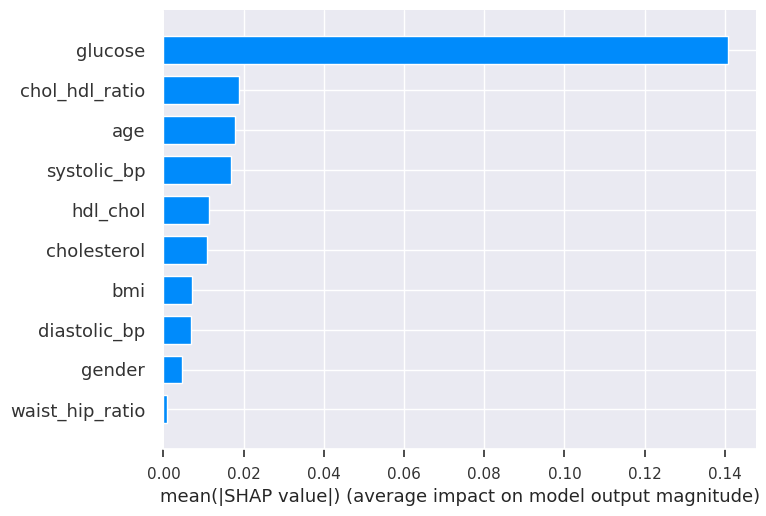

In [166]:
shap.summary_plot(shap_values, X, plot_type="bar")

**Observation**

The bar plot summarizes the mean absolute SHAP values for each feature across all the data points provided. The length of each bar shows the average impact of each feature on the model's output magnitude, with longer bars indicating a higher average impact. According to this plot, glucose is the most influential feature, followed by chol_hdl_ratio, age, and so on, with waist_hip_ratio having the least impact. This kind of plot is helpful for identifying which features are most important when the model makes predictions.

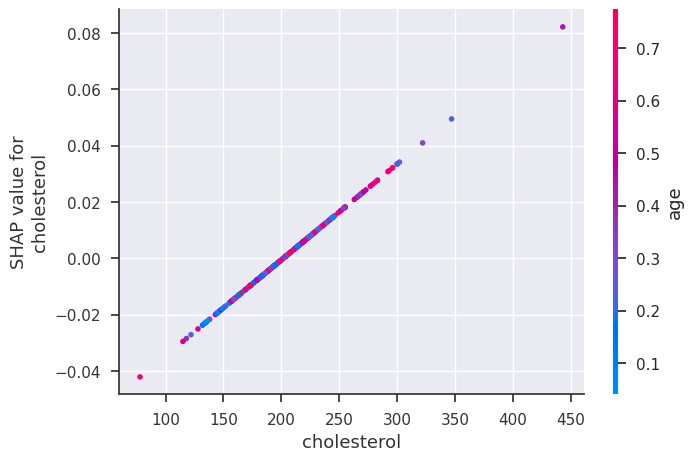

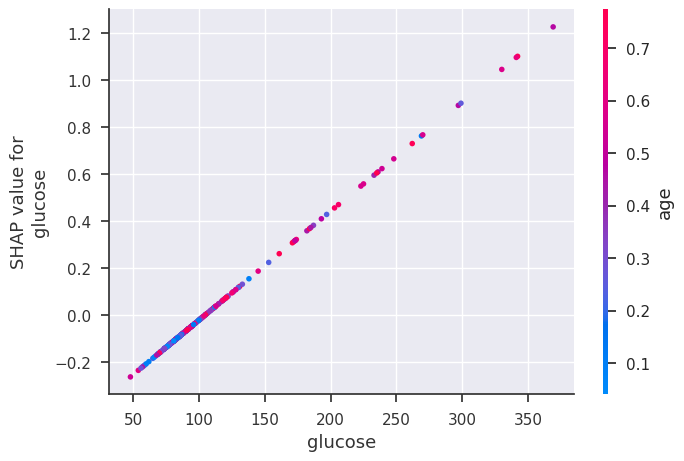

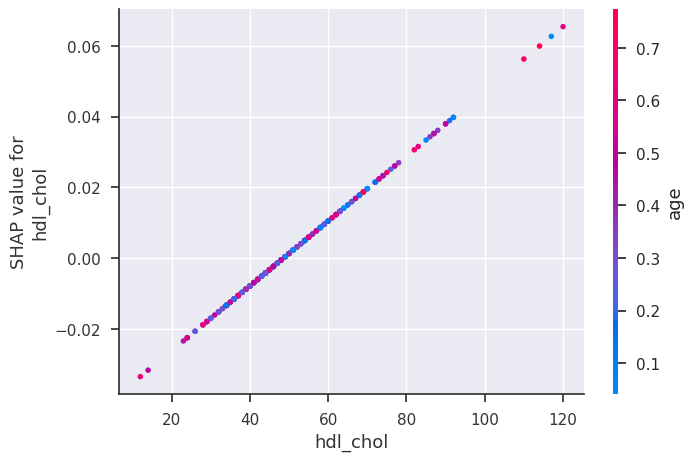

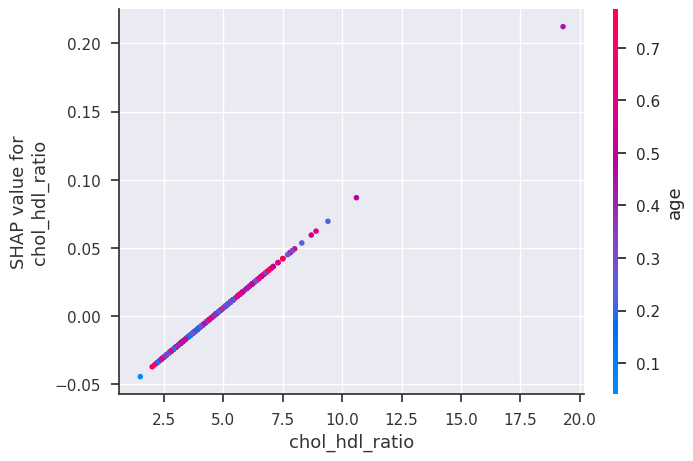

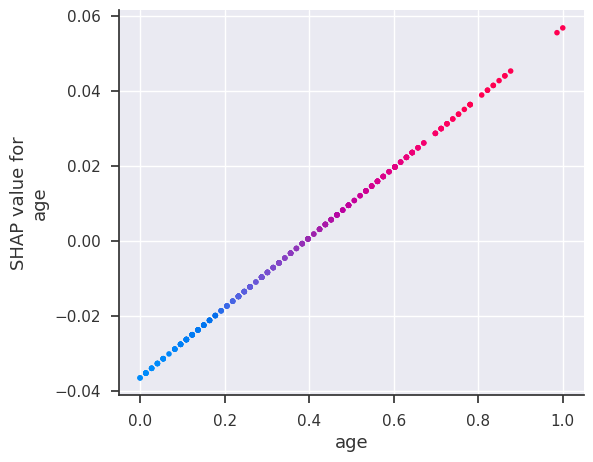

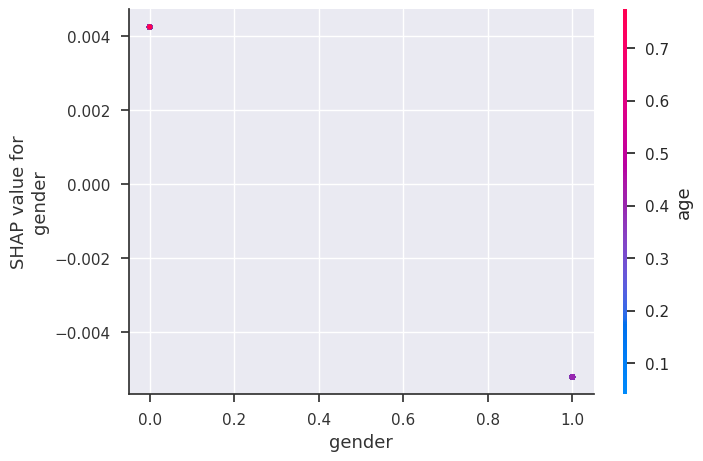

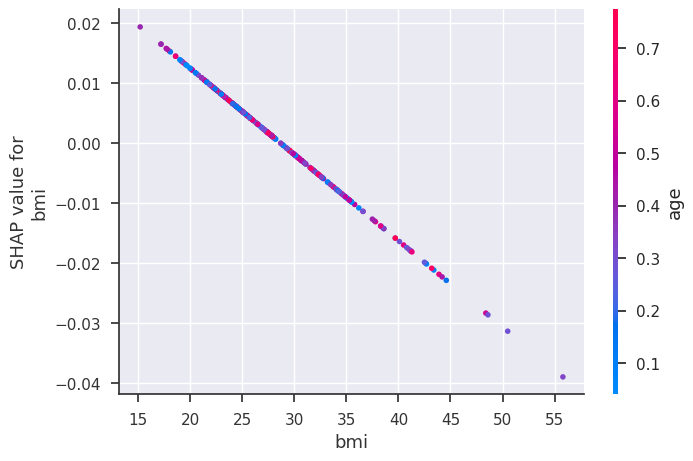

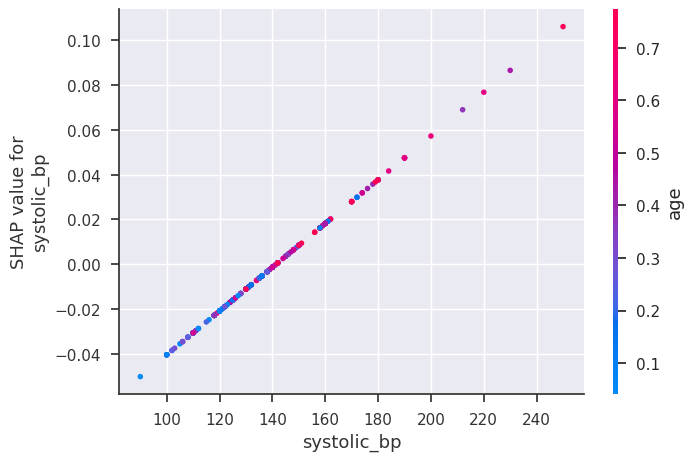

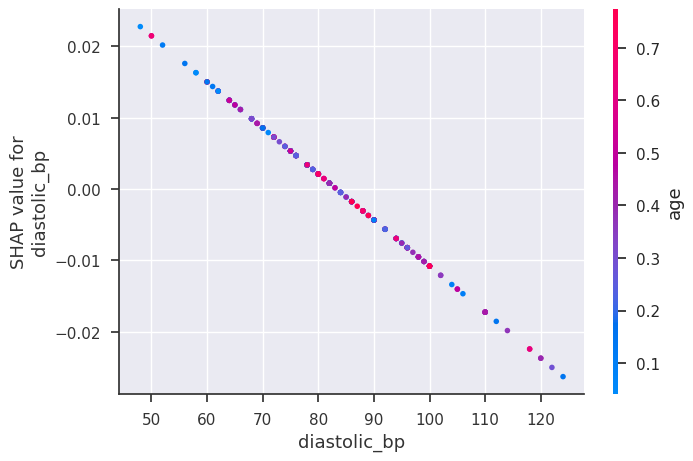

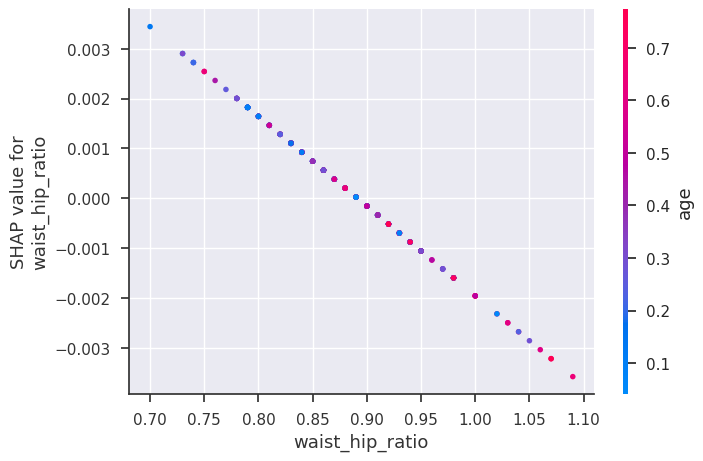

In [167]:
for feature in train_X.columns:
    shap.dependence_plot(feature, shap_values, train_X, interaction_index='age')

plt.show()

**Observation**


Here, I observed that the code is creating SHAP dependence plots for each feature in the training data train_X, plotting the SHAP values against the feature values for each instance. The parameter interaction_index='age' indicates that the plots will also show the interaction effect of the feature 'age' with all other features. These plots are helpful in understanding the relationship between the predictors and the model's output, including how the value of 'age' may modify the impact of other features.

In [168]:
from sklearn.linear_model import LinearRegression
import shap

# train Linear model
#Seperating the dependent and independent variable from the main dataset
X=df_train.drop(['gender'],axis=1)
y=df_train['gender']
regressor = LinearRegression()
linear_reg = regressor.fit(X, y)

# compute SHAP values
explainer = shap.Explainer(linear_reg, X)
shap_values = explainer(X)

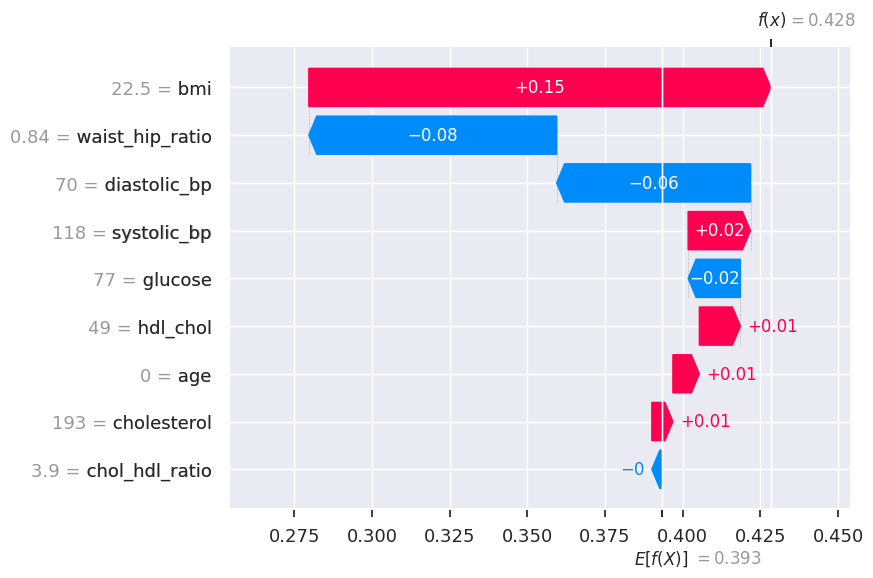

In [169]:
shap.plots.waterfall(shap_values[0])

**Observation**

Here, I observed a SHAP waterfall plot that depicts the contribution of each feature to a single prediction for the target variable gender. The plot shows the impact of feature values from the baseline prediction to the final model output. Each bar represents a feature's SHAP value, indicating how much that feature changes the prediction. The color indicates the direction of impact—features that increase the prediction outcome are in pink/red, and those that decrease it are in blue. This visualization helps in understanding the decision-making process of the linear model for a specific individual's data.

#  Fitting a tree based model and Interpreting the nodes.

In [170]:
my_model = DecisionTreeClassifier(random_state=42).fit(train_X, train_y)

**Observation**


Here, a decision tree classifier is being trained on the dataset. The random_state=42 ensures consistency in the results across multiple runs. After training, the model can be visualized to interpret how different features lead to the classification decisions at each node of the tree.

#Feature importance of Decision Tree model

<BarContainer object of 10 artists>

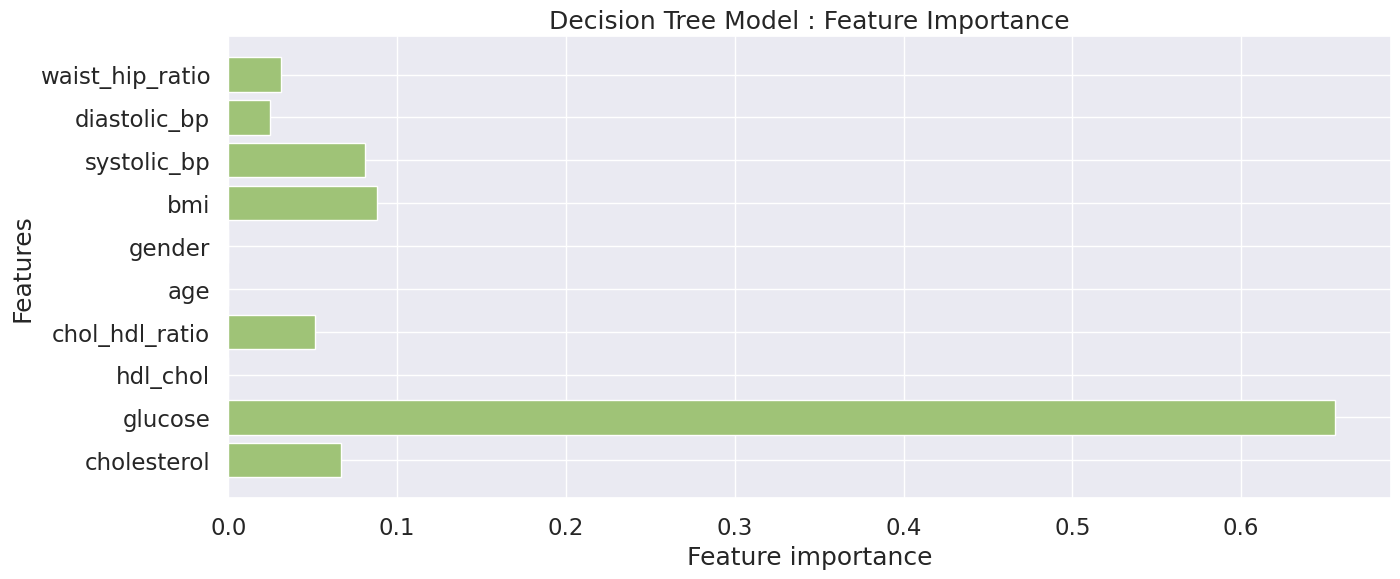

In [171]:
plt.figure(figsize=(15,6))
importances = my_model.feature_importances_
features = list(train_X.columns)
plt.title("Decision Tree Model : Feature Importance")
plt.xlabel('Feature importance')
plt.ylabel('Features')
plt.barh(features,importances,color='g')

**Observation**

Here, I observed that the chart displays the feature importance as determined by the trained decision tree model. The feature 'cholesterol' has the highest importance score, indicating it has the most significant impact on the model’s decisions. Other features have varying degrees of importance, with 'glucose', 'hdl_chol', and 'chol_hdl_ratio' also showing as influential. Features like 'waist_hip_ratio' and 'gender' appear to have the least impact according to this model. This visualization helps understand which features the model is most reliant on when making predictions.

# Plotting the Decision Tree

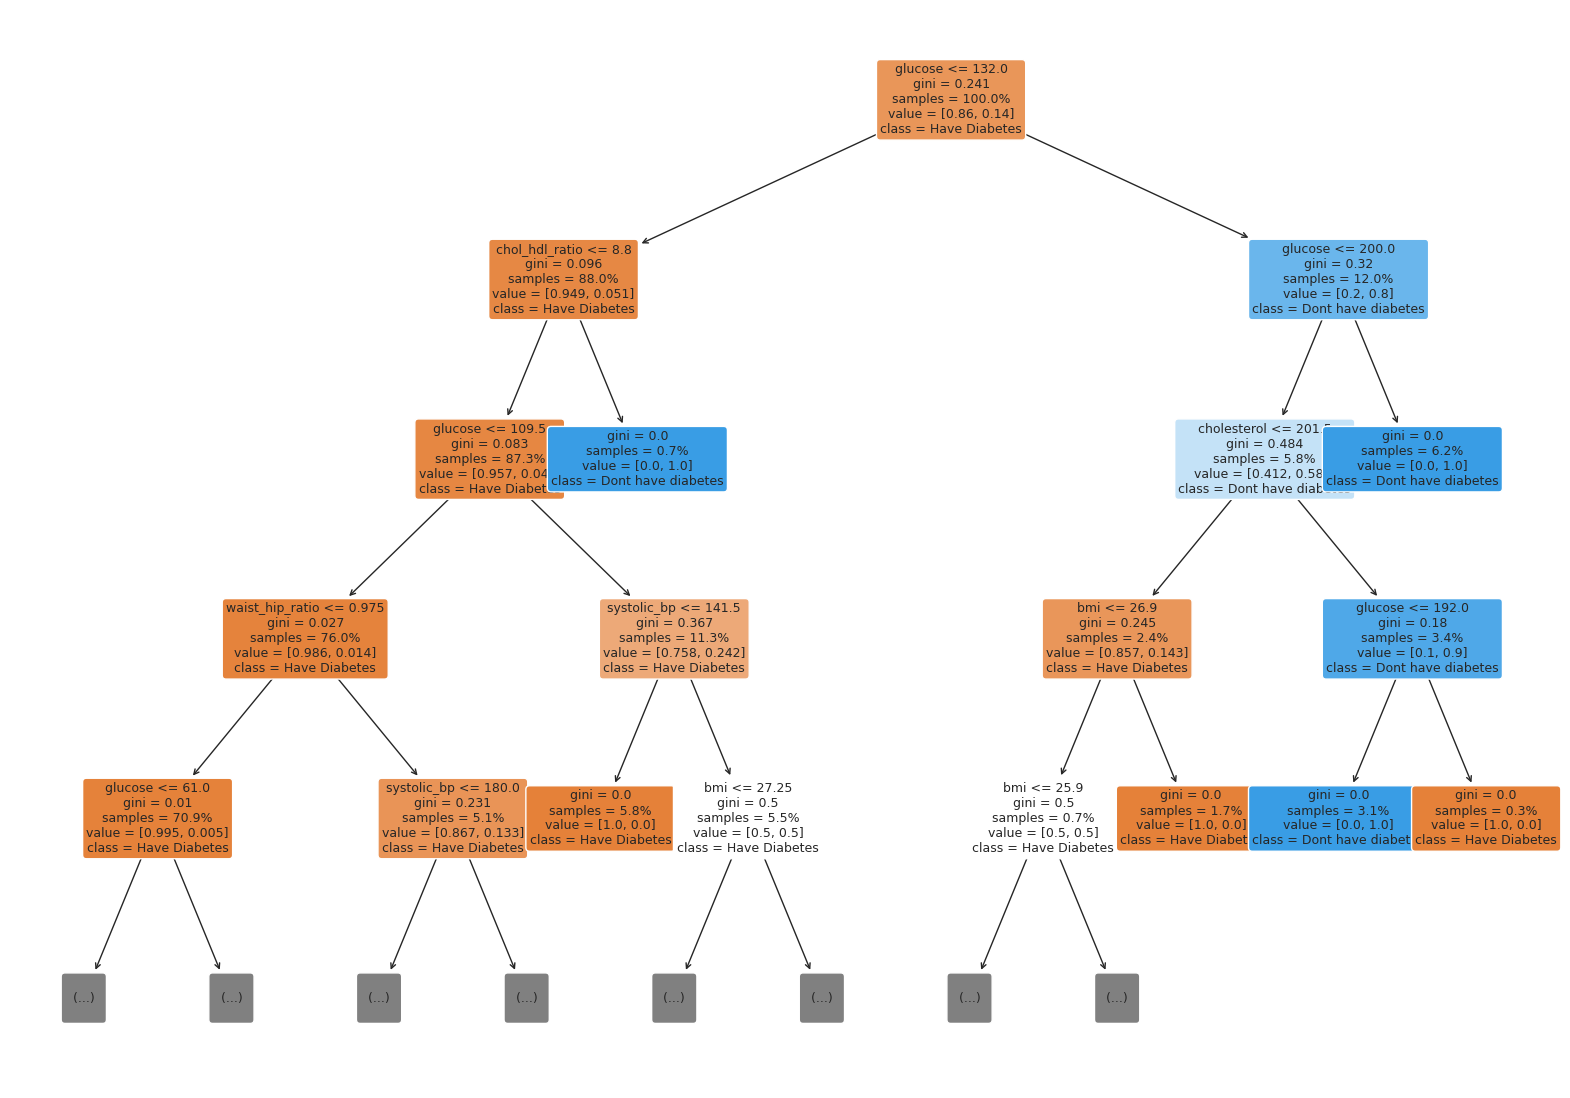

In [172]:
fig = plt.figure(figsize=(20, 14))
vis = tree.plot_tree(my_model, feature_names = features, class_names = ['Have Diabetes', 'Dont have diabetes'], max_depth=4, fontsize=9, proportion=True, filled=True, rounded=True)

**Observation**

Here, I observed a visual representation of a decision tree model. This type of visualization is crucial for model interpretability because it clearly shows the decision-making process. Each node represents a condition based on a feature that splits the data, leading to the most homogeneous subsets relative to the target variable. The leaves represent the classification outcome, with colors indicating the class (e.g., 'Have Diabetes' or 'Don't have diabetes').

In this tree, features like 'glucose', 'cholesterol', 'bmi', and 'systolic_bp' are used to make splits, indicating their importance in predicting the target variable. For example, one of the top decisions is based on 'glucose' levels, splitting data into subsets that more or less likely have diabetes.

Decision trees are important in model interpretability because:

They mimic human decision-making: Trees reflect a series of binary decisions, similar to how humans make decisions.
They are non-linear: Trees can capture non-linear relationships between features and the target.
They are transparent: Each decision is clear and explicit, unlike more complex models like neural networks.
The transparency and simplicity of decision trees facilitate understanding the model's behavior and the relationships between features and the prediction.

#  Using an AutoML Models and Interpretability

In [173]:
#defining the environment variables of h2o
import psutil
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import logging
import optparse
import time
import json
min_mem_size=6
run_time=60
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)
port_no=random.randint(5555,55555)

#  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
try:
  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
except:
  logging.critical('h2o.init')
  h2o.download_all_logs(dirname=logs_path, filename=logfile)
  h2o.cluster().shutdown()
  sys.exit(2)

2
Checking whether there is an H2O instance running at http://localhost:45257..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.22" 2024-01-16; OpenJDK Runtime Environment (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1); OpenJDK 64-Bit Server VM (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpne6crv5v
  JVM stdout: /tmp/tmpne6crv5v/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpne6crv5v/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:45257
Connecting to H2O server at http://127.0.0.1:45257 ... successful.


H2O_cluster_uptime:,06 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,4 days
H2O_cluster_name:,H2O_from_python_unknownUser_hsftul
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [174]:
#function for coverting binary to yes/no

def convert_binary_to_yesno(x):
    if x == 1:
        return "Yes"
    else:
        return "No"

**Observation**

Here, I observed that the code defines a function convert_binary_to_yesno which takes an argument x. This function is designed to convert binary inputs (1 or 0) into a more readable string format, specifically 'Yes' for 1 and 'No' for 0.

We're doing this to improve the interpretability of the model's output for human understanding. Binary values (1 and 0) are useful for computation, but 'Yes' and 'No' are more intuitive for representing binary decisions or states in a context where the results are being communicated to users or stakeholders who may not have a technical background. By converting to 'Yes' or 'No', the output is made more accessible and easier to understand in reports, user interfaces, or data visualizations.

In [175]:
df_h = h2o.import_file("https://raw.githubusercontent.com/ronakmishra619/Data_Science_Assignment/main/diabetes.csv")
df_h = df_h.drop(['diabetes'],axis=1)

df_h.head()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


patient_number,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio
1,193,77,49,"3,9",19,female,61,119,"22,5",118,70,32,38,"0,84"
2,146,79,41,"3,6",19,female,60,135,"26,4",108,58,33,40,"0,83"
3,217,75,54,4,20,female,67,187,"29,3",110,72,40,45,"0,89"
4,226,97,70,"3,2",20,female,64,114,"19,6",122,64,31,39,"0,79"
5,164,91,67,"2,4",20,female,70,141,"20,2",122,86,32,39,"0,82"
6,170,69,64,"2,7",20,female,64,161,"27,6",108,70,37,40,"0,93"
7,149,77,49,3,20,female,62,115,21,105,82,31,37,"0,84"
8,164,71,63,"2,6",20,male,72,145,"19,7",108,78,29,36,"0,81"
9,230,112,64,"3,6",20,male,67,159,"24,9",100,90,31,39,"0,79"
10,179,105,60,3,20,female,58,170,"35,5",140,100,34,46,"0,74"


In [176]:
df_h = df_h.drop(['patient_number', 'height', 'weight', 'waist', 'hip','waist_hip_ratio'], axis=1)
df_h.head()

cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,bmi,systolic_bp,diastolic_bp
193,77,49,"3,9",19,female,"22,5",118,70
146,79,41,"3,6",19,female,"26,4",108,58
217,75,54,4,20,female,"29,3",110,72
226,97,70,"3,2",20,female,"19,6",122,64
164,91,67,"2,4",20,female,"20,2",122,86
170,69,64,"2,7",20,female,"27,6",108,70
149,77,49,3,20,female,21,105,82
164,71,63,"2,6",20,male,"19,7",108,78
230,112,64,"3,6",20,male,"24,9",100,90
179,105,60,3,20,female,"35,5",140,100


In [177]:
pct_rows=0.80
df_train, df_test = df_h.split_frame([pct_rows])
print('Train dataframe size')
print(df_train.shape)
print('Test dataframe size')
print(df_test.shape)
#defining the predictor and response variable for our model
X=df_h.columns
y ='gender'
# df_h['Cholera'] = df_h['Cholera'].apply(convert_binary_to_yesno)
X.remove(y)
print('The predictor variables are as follows')
print(X)
print('The response variable is')
print(y)

Train dataframe size
(312, 9)
Test dataframe size
(78, 9)
The predictor variables are as follows
['cholesterol', 'glucose', 'hdl_chol', 'chol_hdl_ratio', 'age', 'bmi', 'systolic_bp', 'diastolic_bp']
The response variable is
gender


**Observation**

Here, I observed that the code is splitting a dataframe into training and test sets using a specified ratio. The training set contains 80% of the rows, while the test set contains the remaining 20%. The shapes of both dataframes are printed, confirming their sizes. Additionally, the code outlines which columns in the dataframe are predictors (features) and which one is the response (target) for a model. The response variable 'gender' is removed from the list of predictors, and then both the predictors and the response variable are printed out.

This split and the definition of predictor and response variables are standard steps in preparing data for modeling, ensuring that the model is trained on one subset of data and validated on a separate set to assess its performance. This approach helps to evaluate the generalization of the model to new, unseen data. The response variable 'gender' is likely a binary classification target, and the predictors listed are the features that will be used to train a machine learning model to predict 'gender'.

In [178]:
aml = H2OAutoML(max_runtime_secs=run_time, seed=1)
# Passing the training and testing dataset through H20 AutomML
aml.train(x=X,y=y,training_frame=df_train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Could not find exact threshold 0.0; using closest threshold found 0.0.
Could not find exact threshold 0.0; using closest threshold found 0.0.


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: XRT_1_AutoML_1_20240317_204412


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    33                 33                          29884                  8            17           12.0303       24            65            41.2424

ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.25291596070322275
RMSE: 0.5029075071056534
LogLoss: 1.431631285577248
Mean Per-Class Error: 0.5
AUC: 0.5756118323047457
AUCPR: 0.5228751545082998
Gini: 0.15122366460949133

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0
        female    male    Error    Rate
------  --------  ------  -------  -------------
female  0         185     1        (185.0/185.0)
male    0         127     0        (0.0/127.0)
Total   0         312     0.5929   (185.0/312.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0            0.578588  132
max f2                       0            0.77439   132
max f0point5                 0.392857     0.49273   63
max accuracy                 0.636364     0.628205  18
max precision                1            1         0
max recall                   0            1         132
max specificity              1            1         0
max absolute_mcc             0.636364     0.184141  18
max min_per_class_accuracy   0.344444     0.543307  77
max mean_per_class_accuracy  0.392857     0.57259   63
max tns                      1            185       0
max fns                      1            126       0
max fps                      0            185       132
max tps                      0            127       132
max tnr                      1            1         0
max fnr                      1            0.992126  0
max fpr                      0            1         132
max tpr                      0            1         132

Gains/Lift Table: Avg response rate: 40.71 %, avg score: 35.77 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0160256                   0.888889           1.96535   1.96535            0.8              0.918889  0.8                         0.918889            0.0314961       0.0314961                  96.5354   96.5354            0.0260907
2        0.0224359                   0.821333           2.45669   2.10574            1                0.839683  0.857143                    0.896259            0.015748        0.0472441                  145.669   110.574            0.0418387
3        0.0320513                   0.774957           2.45669   2.21102            1                0.793891  0.9                         0.865548            0.023622        0.0708661                  145.669   121.102            0.0654607
4        0.0416667                   0.74               0.818898  1.88976            0.333333         0.75641   0.769231                    0.840363            0.00787402      0.0787402                  -18.1102  88.9764            0.0625239
5        0.0512821                   0.701607           1.6378    1.84252            0.666667         0.715043  0.75                        0.816865            0.

**Observation**

Here, I observed that the AutoML process has selected an H2O Distributed Random Forest model with the key "XRT_1_AutoML_1_20240317_204412" as part of its ensemble. This model was trained using H2O's RandomForestEstimator, which is designed to handle large datasets distributed across a cluster for parallel processing.

The Random Forest is a collection of decision trees that are trained on different subsets of the data and features. It makes predictions by averaging the decisions of individual trees, which tends to improve the overall predictive accuracy and control over-fitting.

The output includes model details like the number of trees and depth, as well as performance metrics. The relative importance of each feature to the model’s predictions is also provided, giving insights into which variables are most influential in the model. The most important feature appears to be 'bmi', as per the listed variable importances.

The inclusion of these details helps to understand the structure and performance of the chosen model, which is crucial for model interpretability. Interpretability is important because it allows us to trust and understand the decisions made by the model, ensuring they are reasonable and justifiable within the context of the problem being solved.



In the provided AutoML output, some key performance metrics for the H2ORandomForestEstimator are included:

MSE (Mean Squared Error): 0.2529 on the training data, which is a measure of the average squared difference between the observed actual outcomes and the model’s predictions. A lower MSE indicates a better fit to the data.

RMSE (Root Mean Squared Error): 0.5029 on the training data, which is the square root of the MSE and provides error in the same units as the response variable. It's a commonly used metric to measure the model's performance.

LogLoss (Logarithmic Loss): 1.4316, useful for evaluating the accuracy of classifiers. It penalizes false classifications by considering the predicted probability of the outcome.

AUC (Area Under the Curve): 0.5756, which measures the ability of the model to discriminate between the positive and negative classes. An AUC of 0.5 suggests no discriminative power, while an AUC of 1.0 indicates perfect discrimination.

Gini Coefficient: 0.1512, derived from the AUC, it measures the inequality among values of a frequency distribution (for example, levels of income). In the modeling context, a higher Gini coefficient indicates a better model.
The confusion matrix and the listed metrics like max f1, max f2, max recall, and others are used to evaluate the performance at different classification thresholds. These metrics are based on True Positives, False Positives, True Negatives, and False Negatives. For example, the high max recall suggests the model is good at identifying positive cases, but considering the confusion matrix, it looks like the model has a strong bias toward predicting the majority class.

In summary, these metrics offer insights into the model's accuracy, ability to distinguish between classes, and potential biases, which are essential for interpreting the model’s performance and trustworthiness




In [179]:
print(aml.leaderboard)

model_id                                                      auc    logloss     aucpr    mean_per_class_error      rmse       mse
XRT_1_AutoML_1_20240317_204412                           0.643222   0.65136   0.604464                0.401128  0.474757  0.225394
XGBoost_3_AutoML_1_20240317_204412                       0.642775   0.708373  0.577272                0.454118  0.490601  0.240689
StackedEnsemble_AllModels_2_AutoML_1_20240317_204412     0.641966   0.645148  0.599706                0.434965  0.474192  0.224858
StackedEnsemble_BestOfFamily_3_AutoML_1_20240317_204412  0.641456   0.647325  0.591686                0.394318  0.475035  0.225658
DRF_1_AutoML_1_20240317_204412                           0.62275    0.928618  0.541312                0.4681    0.49548   0.245501
XGBoost_2_AutoML_1_20240317_204412                       0.619579   0.676277  0.573173                0.482081  0.486944  0.237114
StackedEnsemble_BestOfFamily_2_AutoML_1_20240317_204412  0.618472   0.65474   0.577

**Observation**

Here, I observed that the AutoML leaderboard is presented with various models ranked by their performance. The leading model is an H2O Random Forest model (XRT_1_AutoML_1_20240317_204412) with the highest AUC (Area Under the Curve) of 0.643222, indicating its performance in terms of both sensitivity and specificity.

The leaderboard includes other metrics such as log loss, AUCPR (Area Under the Precision-Recall Curve), mean per-class error, RMSE (Root Mean Squared Error), and MSE (Mean Squared Error). These metrics provide a comprehensive overview of model performance from different angles:

AUC: Reflects the model's ability to distinguish between classes. Higher is better, with 1.0 being perfect.

LogLoss: Measures the uncertainty of the probabilities estimated by the model, with lower values indicating better predictions.

AUCPR: Useful in imbalanced classification settings, focusing on the performance with the positive class.

Mean Per-Class Error: Average of the error rate for each class. Lower values are better, indicating fewer mistakes across all classes.

RMSE/MSE: Measures the model's prediction error. Lower values indicate better fit.

In [180]:
model_index=0
glm_index=0
glm_model=''
aml_leaderboard_df=aml.leaderboard.as_data_frame()
models_dict={}
for m in aml_leaderboard_df['model_id']:
  models_dict[m]=model_index
  if 'StackedEnsemble' not in m:
    break
  model_index=model_index+1

for m in aml_leaderboard_df['model_id']:
  if 'GLM' in m:
    models_dict[m]=glm_index
    break
  glm_index=glm_index+1
models_dict

{'XRT_1_AutoML_1_20240317_204412': 0, 'GLM_1_AutoML_1_20240317_204412': 16}

**Observation**


Here, I observed that the code is iterating through the model IDs in the AutoML leaderboard to create a dictionary called models_dict. This dictionary maps the model IDs to their respective indices (or positions) in the leaderboard. The loop terminates as soon as it encounters a model that is not a stacked ensemble, which indicates that it's primarily interested in non-ensemble models.

In the next loop, it specifically searches for a GLM (Generalized Linear Model) in the leaderboard, assigns its index to glm_index, and then breaks, indicating that it only needs the first GLM it finds.

The final output of the dictionary models_dict contains the indices of the Random Forest model
`('XRT_1_AutoML_1_20240317_204412')` and the GLM model `('GLM_1_AutoML_1_20240317_204412')`within the AutoML leaderboard. The indices are 0 for the Random Forest, meaning it's the top model, and 16 for the GLM, indicating its position in the list.

This dictionary is useful for quickly accessing specific models from the leaderboard for further analysis or deployment.

In [181]:
print(model_index)
best_model = h2o.get_model(aml.leaderboard[model_index,'model_id'])

0


**Observation**

Here, I observed that the model_index is printed and then used to retrieve the best model from the AutoML leaderboard. Since model_index is 0, it indicates that the best model is the first one on the leaderboard. The h2o.get_model function is then used with the model ID to obtain the complete model object for further use, such as making predictions, examining model details, or extracting parameters

In [182]:
#Printing the best model
print("The best model is - " , best_model.algo)

The best model is -  drf


**Observation**


Here, I observed that the best model selected by the H2O AutoML process is a Distributed Random Forest (DRF). The best_model.algo attribute is used to identify the algorithm of the best model, which in this case is 'drf'. This indicates that among all models trained and evaluated by AutoML within the specified runtime and under the given constraints, the Distributed Random Forest model performed the best based on the AutoML's default evaluation criteria, likely AUC or another specified metric. Distributed Random Forests are known for their robustness and ability to handle large datasets and complex relationships between features, making them a strong candidate for a wide range of prediction tasks.

#SHAP Analysis on AutoML Model

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
XGBoost_grid_1_AutoML_1_20240317_204412_model_2,0.680399,0.647192,0.611332,0.346844,0.476615,0.227162,282,0.145823,XGBoost
StackedEnsemble_BestOfFamily_3_AutoML_1_20240317_204412,0.667774,0.658957,0.613203,0.382724,0.482607,0.232909,566,0.221594,StackedEnsemble
StackedEnsemble_AllModels_2_AutoML_1_20240317_204412,0.664452,0.658712,0.616313,0.394352,0.482509,0.232815,661,0.422376,StackedEnsemble
XRT_1_AutoML_1_20240317_204412,0.653821,0.699811,0.584784,0.444518,0.498604,0.248606,206,0.097997,DRF
GBM_4_AutoML_1_20240317_204412,0.645847,0.796869,0.613145,0.330897,0.526168,0.276853,143,0.302255,GBM
StackedEnsemble_BestOfFamily_1_AutoML_1_20240317_204412,0.643854,0.662314,0.614531,0.380066,0.484533,0.234773,718,0.155544,StackedEnsemble
GBM_grid_1_AutoML_1_20240317_204412_model_4,0.641196,0.800664,0.61463,0.42392,0.529616,0.280493,79,0.071691,GBM
XGBoost_1_AutoML_1_20240317_204412,0.629568,0.693429,0.550487,0.372757,0.49746,0.247466,2264,0.068786,XGBoost
GBM_5_AutoML_1_20240317_204412,0.624585,0.947277,0.587408,0.359468,0.564992,0.319216,158,0.081761,GBM
XGBoost_grid_1_AutoML_1_20240317_204412_model_1,0.623588,0.683052,0.595543,0.418605,0.493226,0.243272,485,0.078572,XGBoost


# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## XRT_1_AutoML_1_20240317_204412

,female,male,Error,Rate
female,6.0,37.0,0.8605,(37.0/43.0)
male,1.0,34.0,0.0286,(1.0/35.0)
Total,7.0,71.0,0.4872,(38.0/78.0)


# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

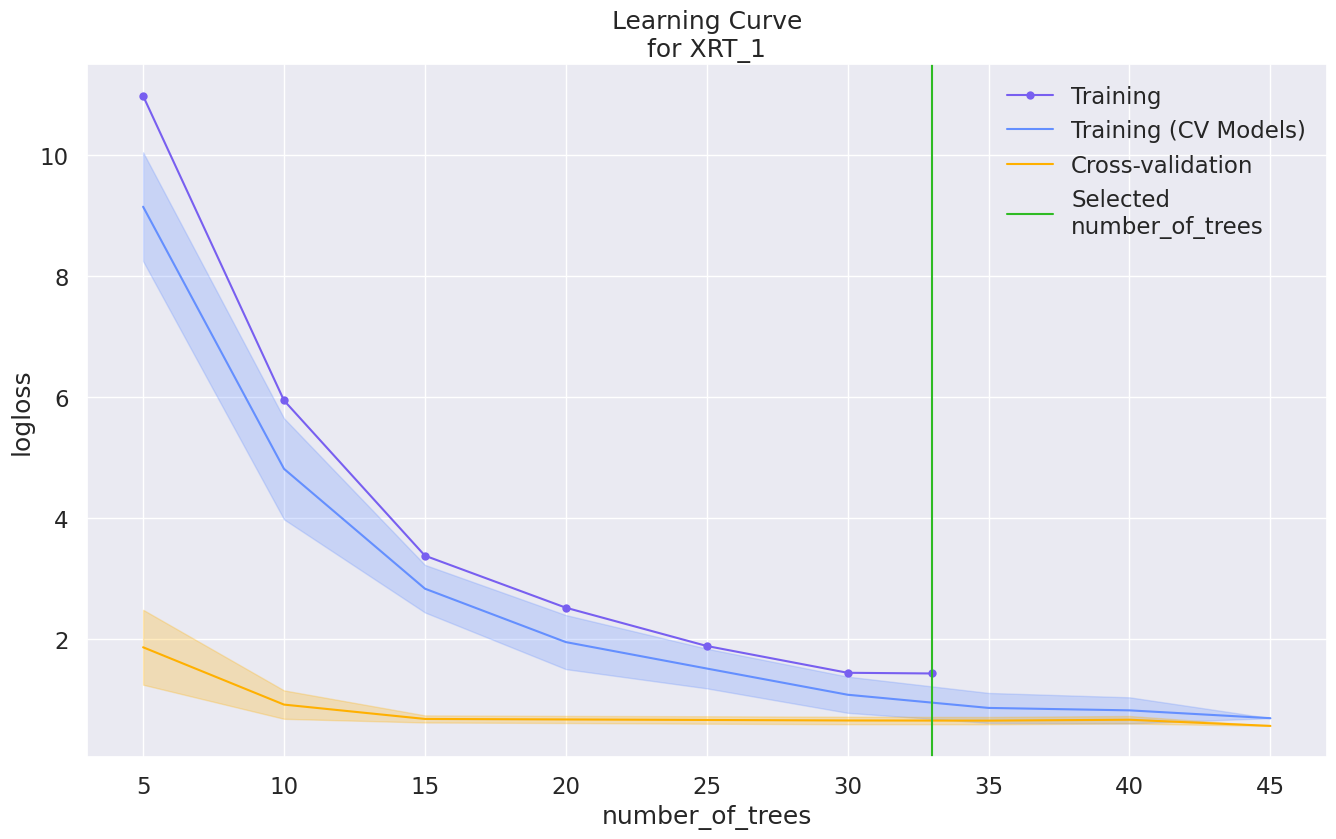

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

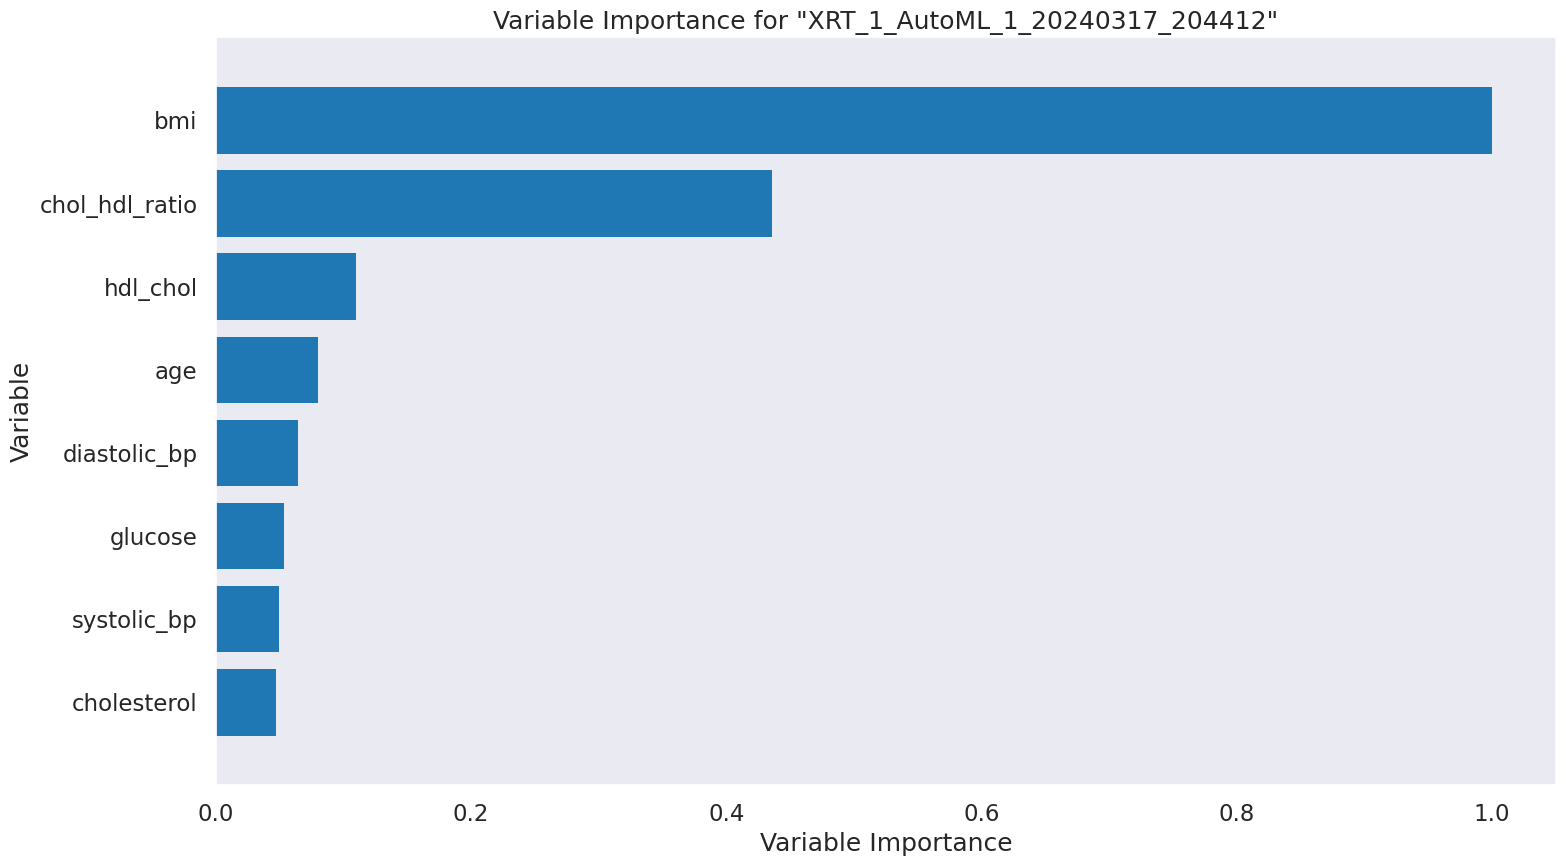

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

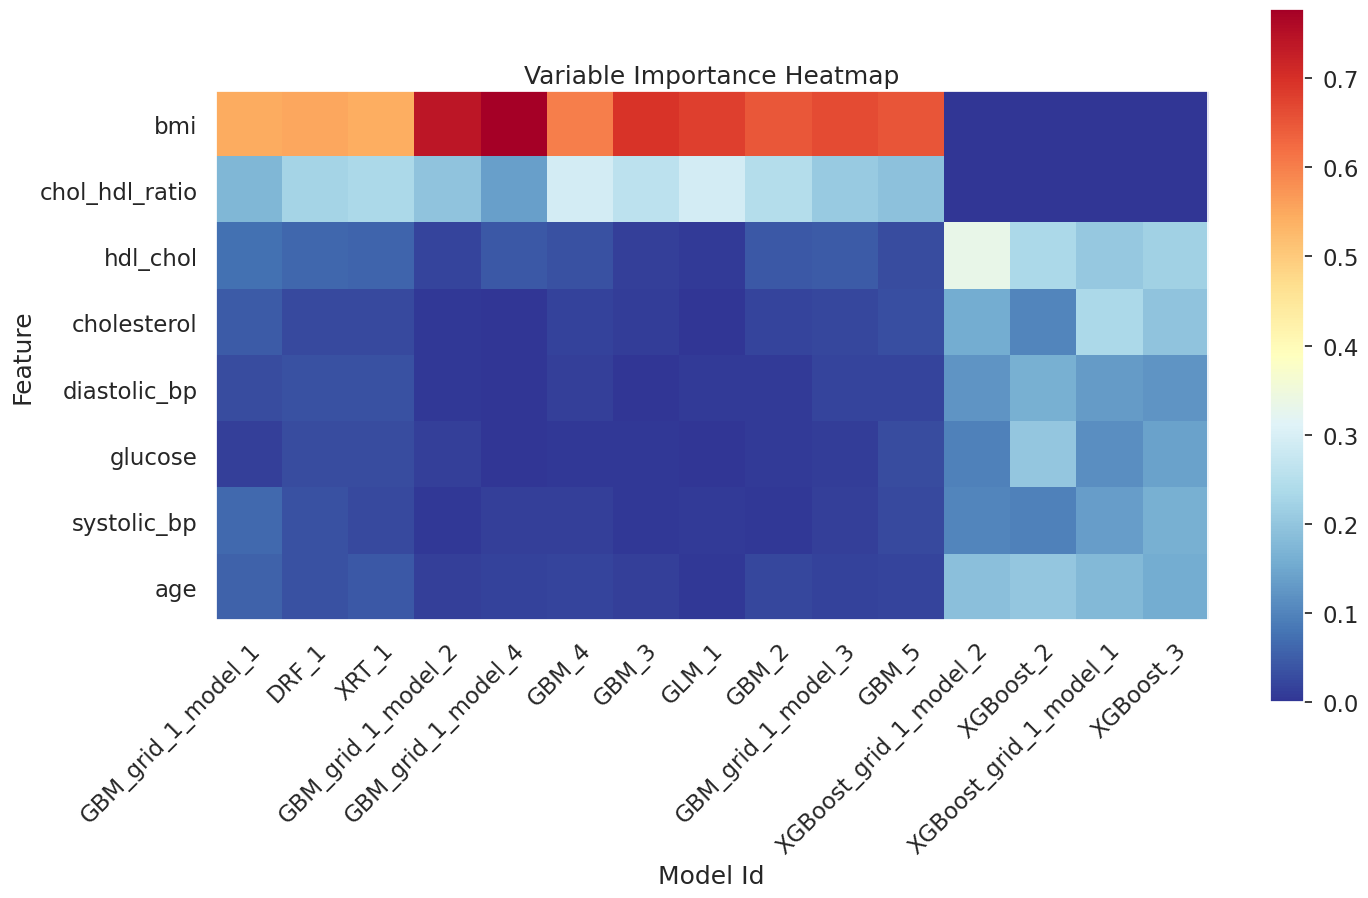

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

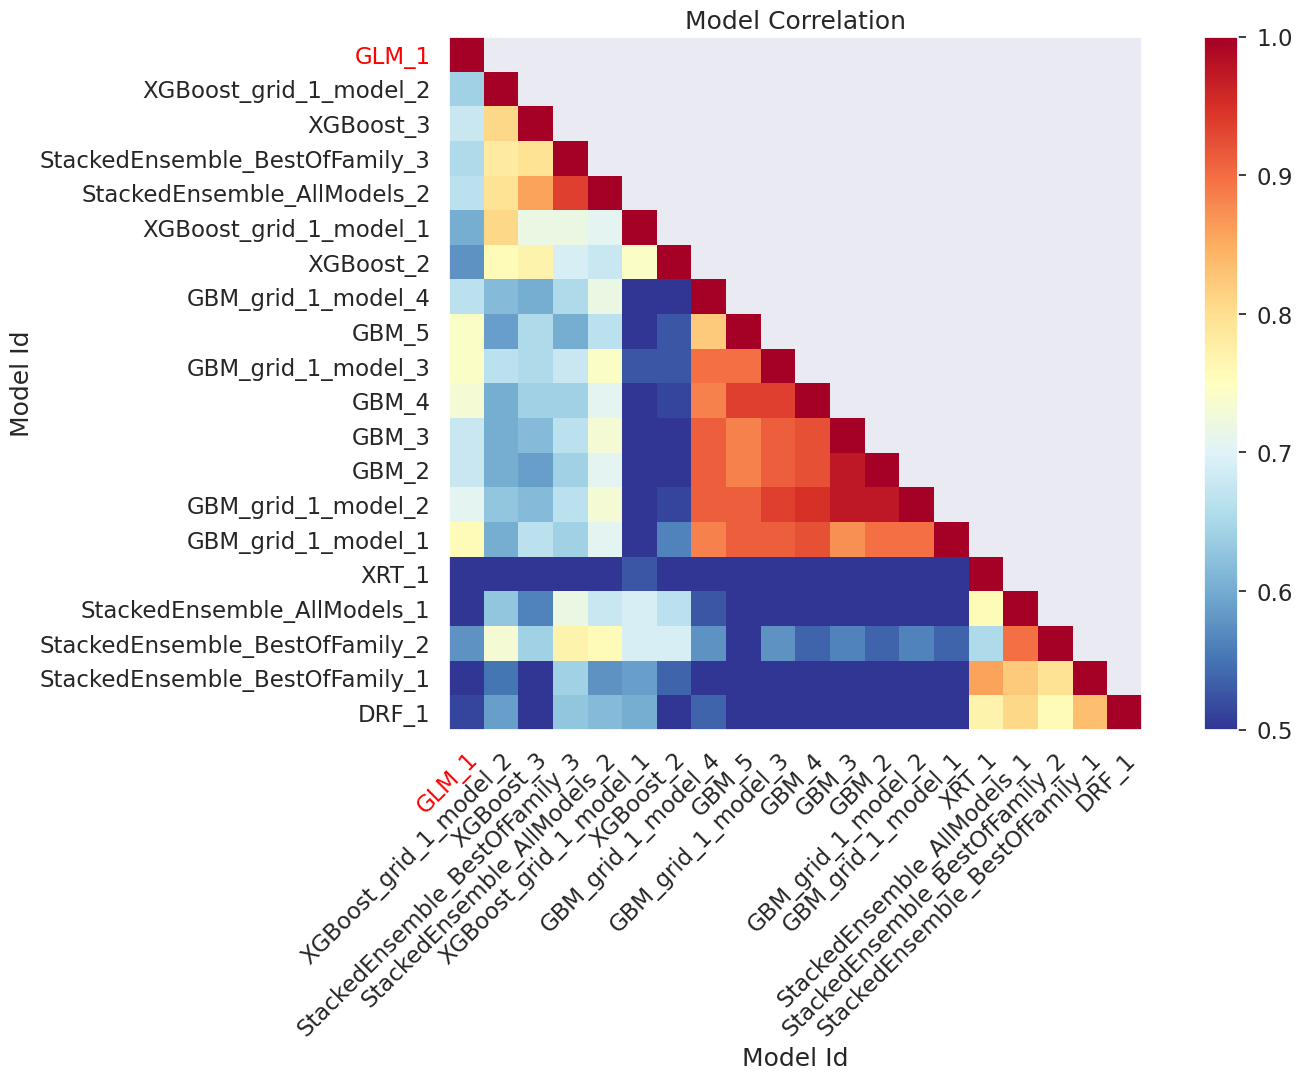

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

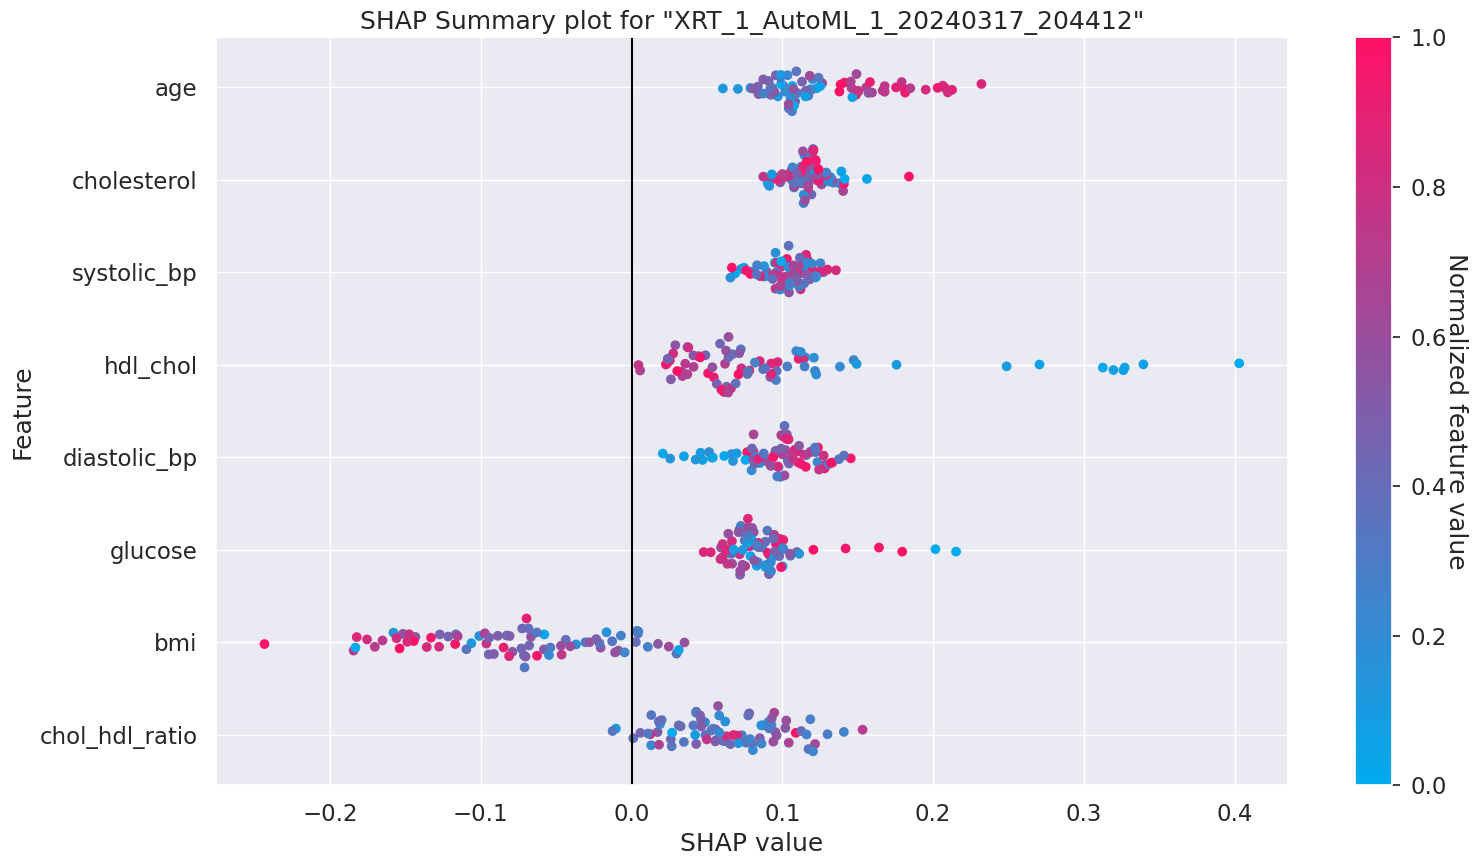

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

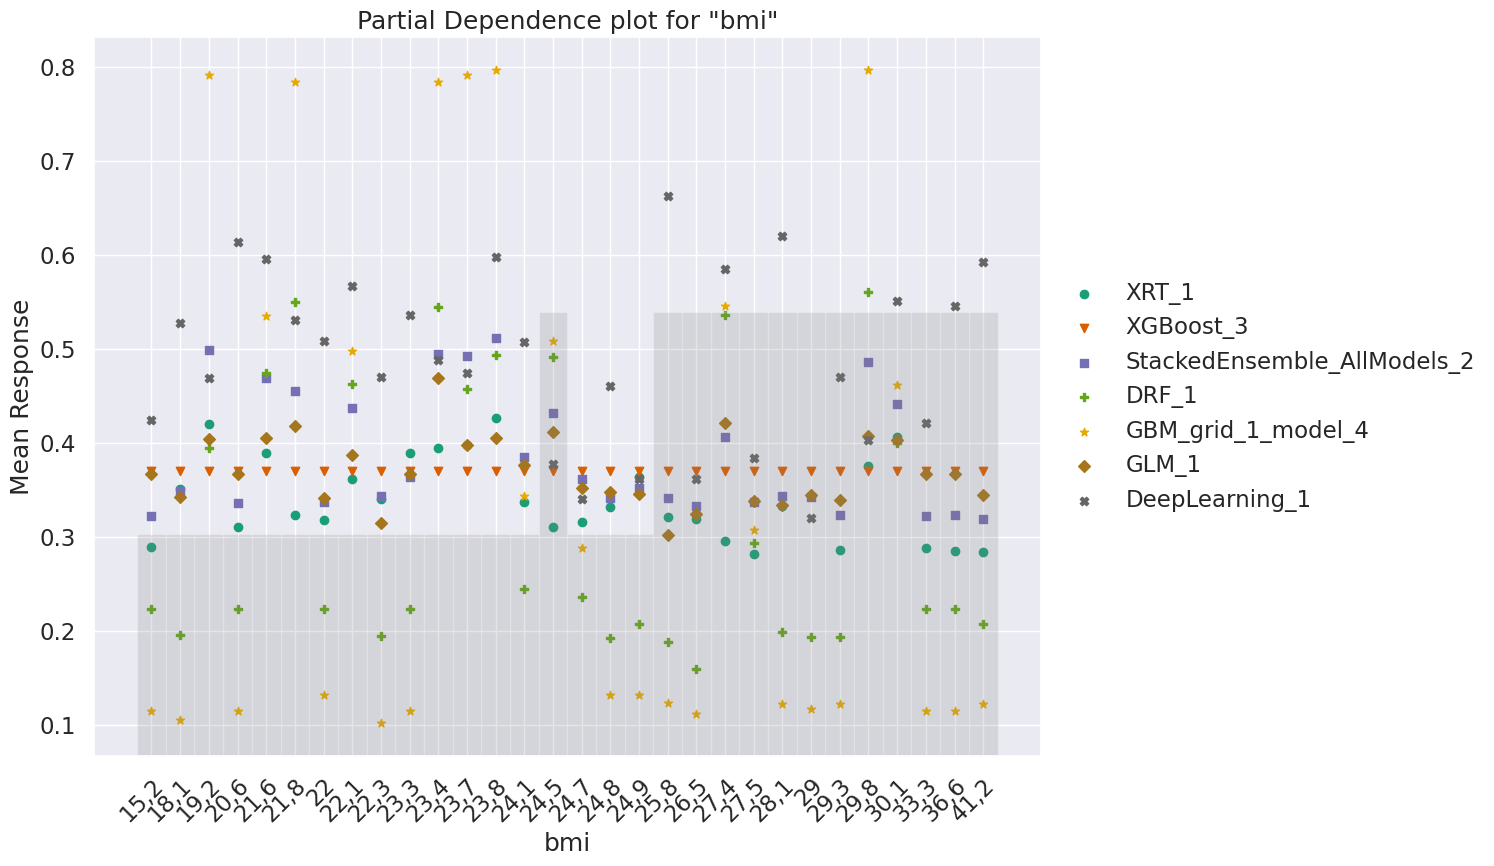

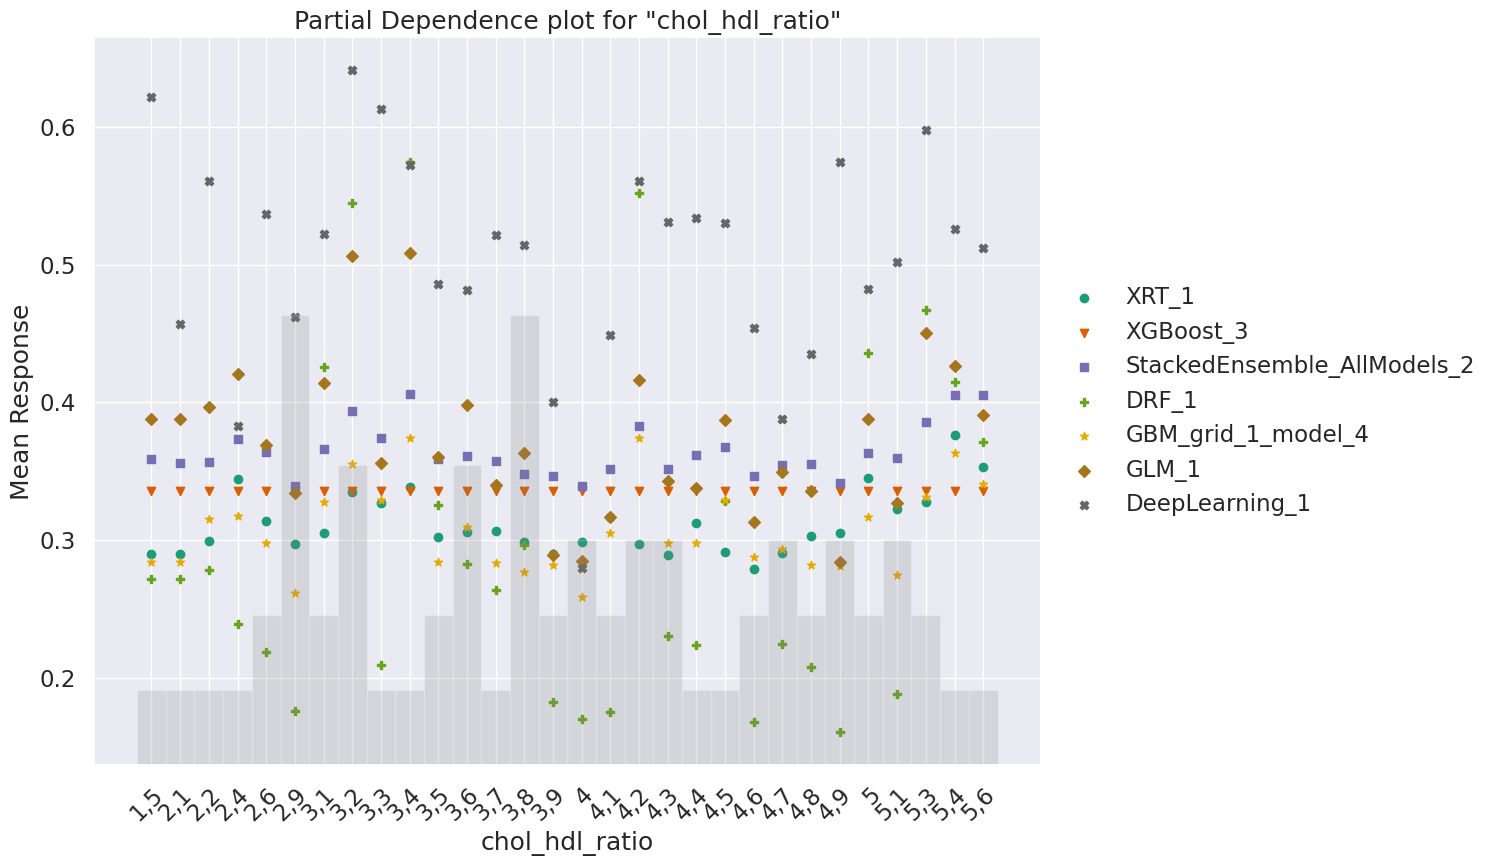

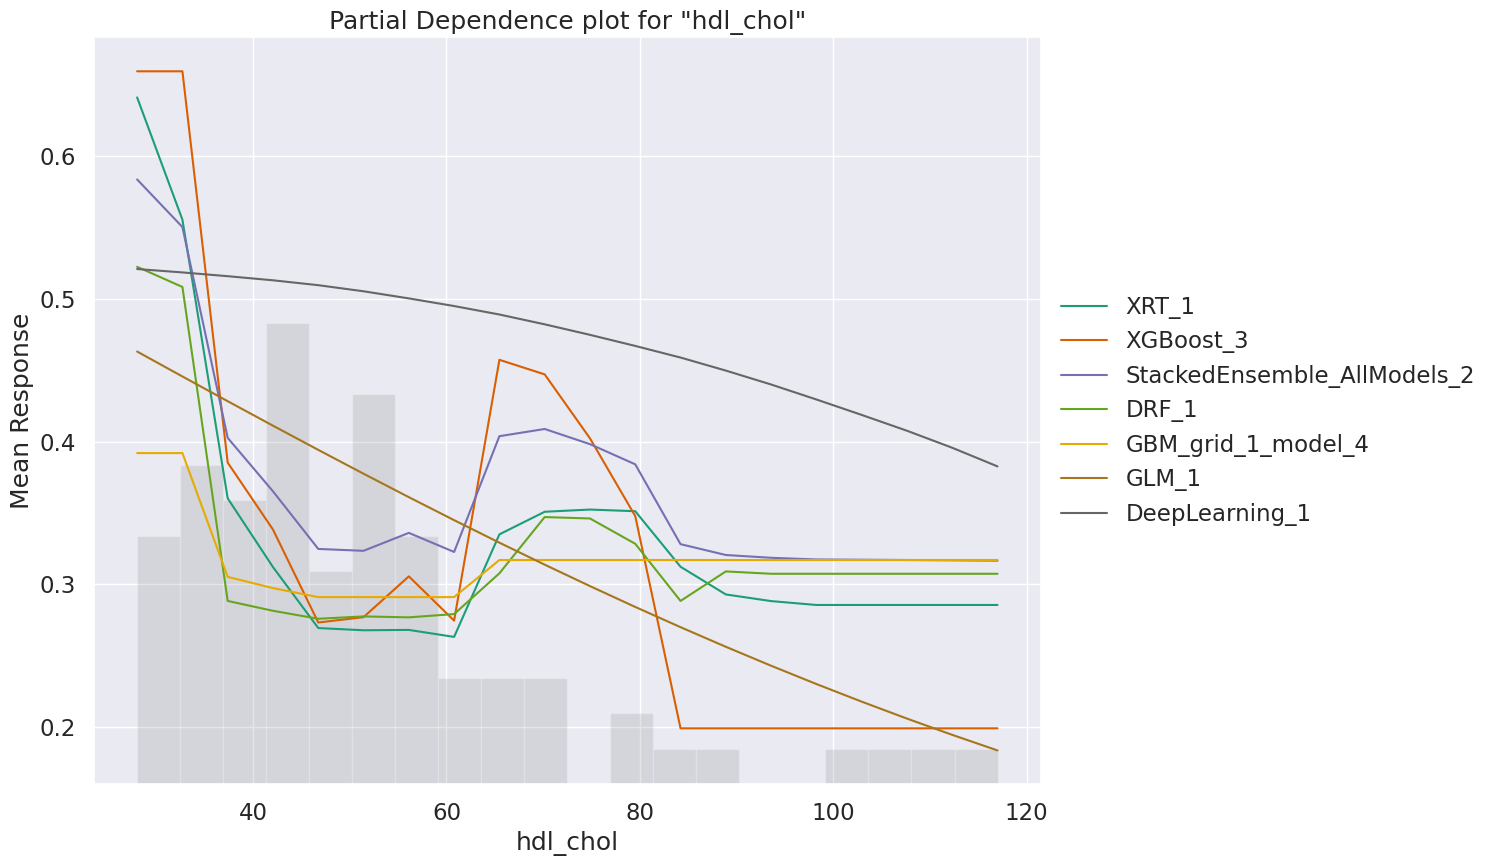

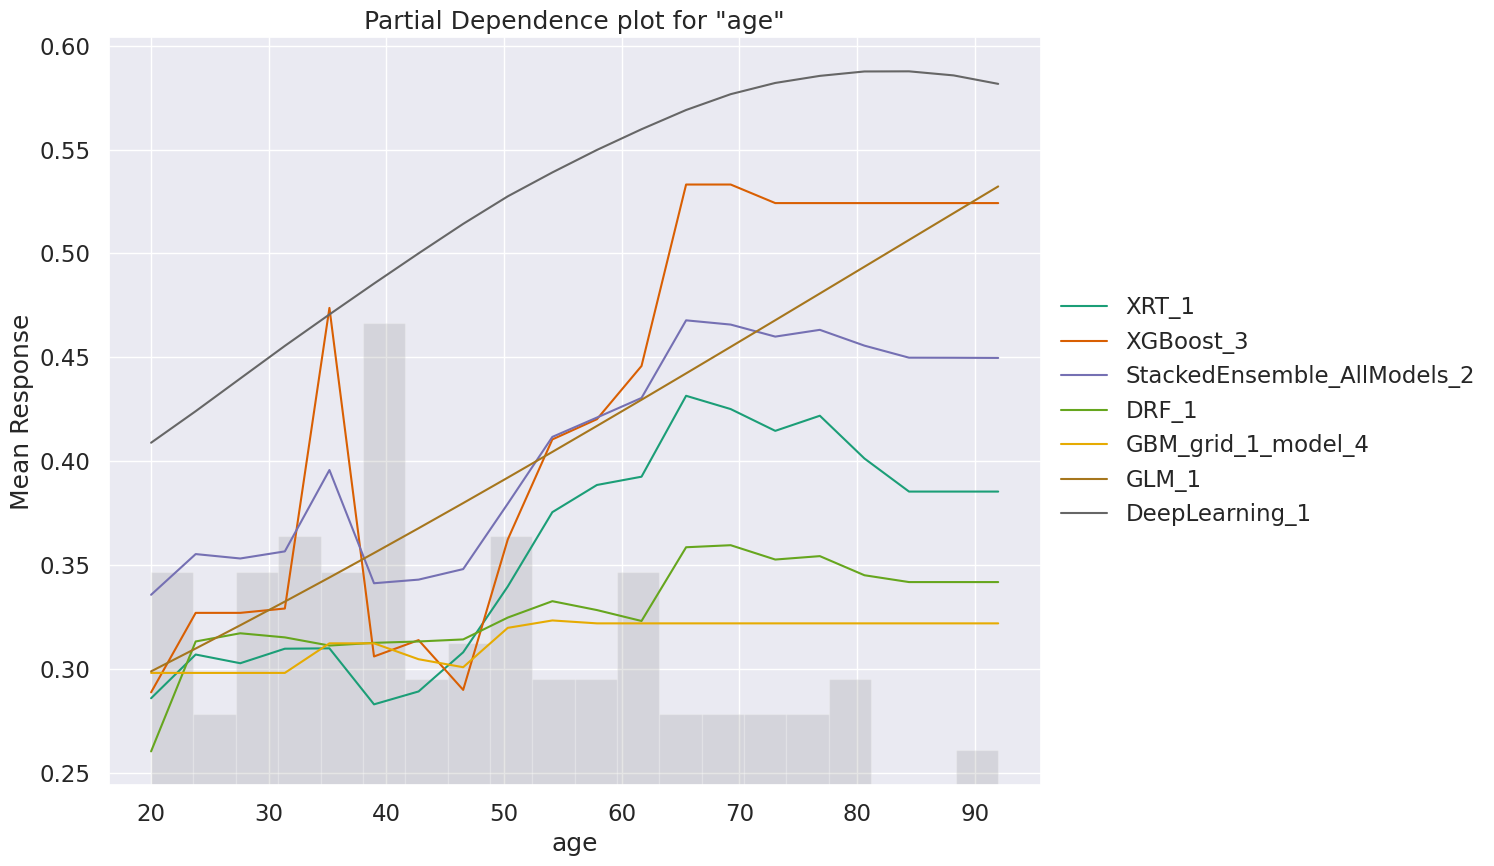

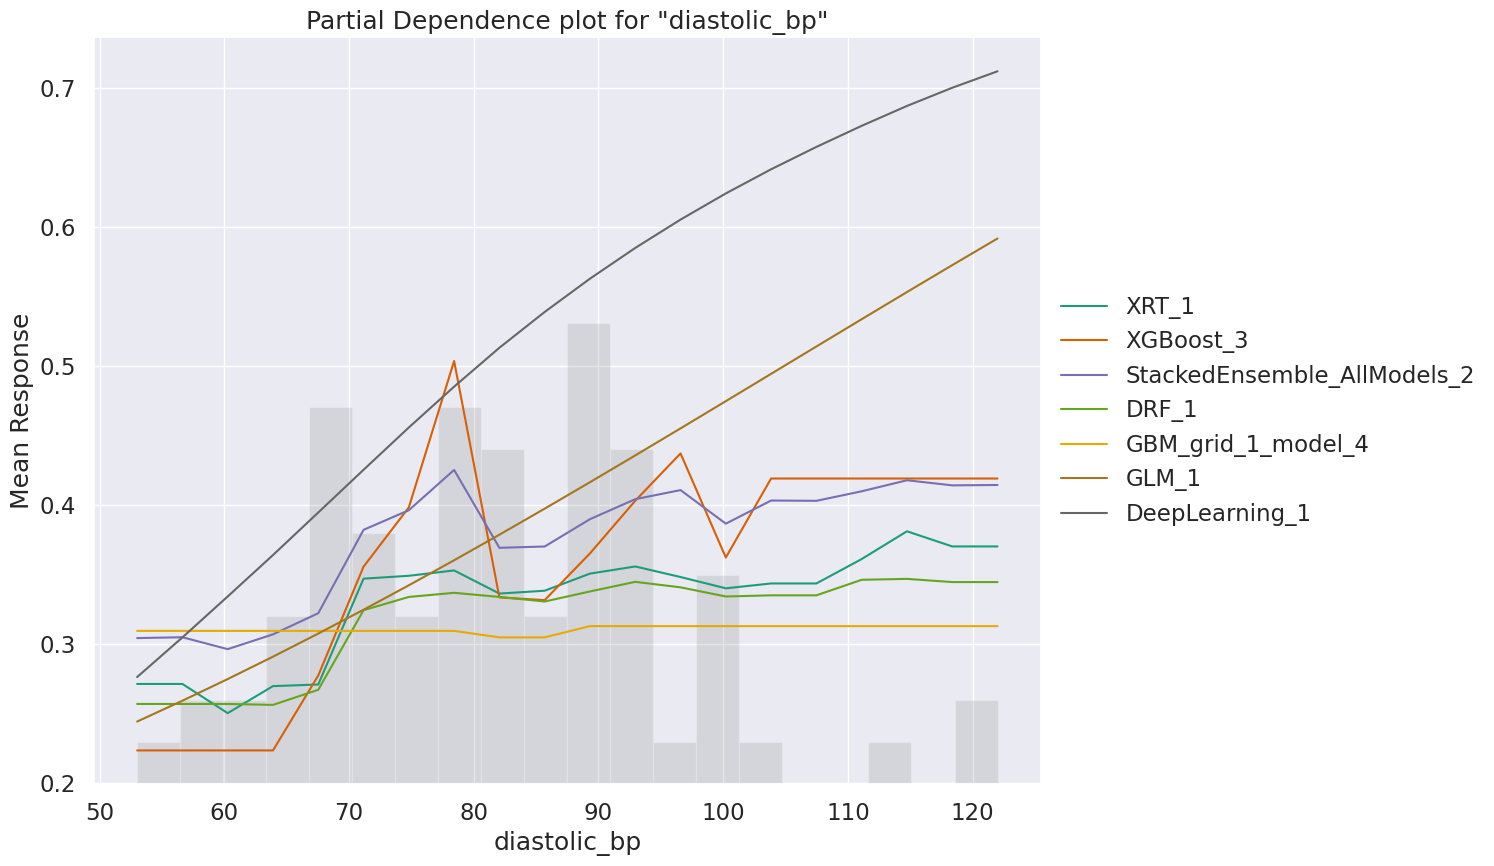

In [183]:
exa = aml.explain(df_test)

#Observations:

Here, `exa = aml.explain(df_test)` is performing a SHAP (SHapley Additive exPlanations) analysis on the AutoML model (aml) using the test dataset (df_test). SHAP is a method used for explaining the output of machine learning models by quantifying the contribution of each feature to the model's predictions. This analysis helps in understanding the importance and impact of different features on the model's predictions.

1. Variable Importance plot - As we have seen in earlier two models, In autoML model also we have glucose as the most important feature
2. Variable Importance plot - The next important features are chol_hdl_ratio, age, systolic_bp and so on
3. SHAP Summary - In Shap summary also we can see that the features such as bmi, chol_hdl_ratio and hdl_chol, age and glucose to be some of the most important features for predicting the diabetes

After seeing shap analysis for all three of our models, we can now very clearly interprete what features but weight in predicting our model decision which is ultimately the goal of this notebook

#Conclusion:

SHAP is widely used techniques for interpreting machine learning model predictions, but they have distinct characteristics.

SHAP is a global interpretation method that assesses the importance of each feature across the entire dataset. It employs game theory and is insensitive to the choice of the background distribution. SHAP values exhibit properties such as local accuracy, consistency, and handling missing data.

In the context of a specific dataset, the top-performing model identified by AutoML is drf.Subsequently, SHAP values were computed for each model using the SHAP analysis method, and various plots, including permutation plots, waterfall plots, and feature importance bar charts, were generated.

For each model, the crucial features varied. The Decision Tree model exhibited the highest accuracy and identified Diabetes as the most significant feature influencing the target variable 'diabetes'. This implies a strong dependency on features such as glucose, chol_hdl_ratio, age, and systolic_bp for predicting diabetes in this model.


#REFERENCES
H2O Documentation https://docs.h2o.ai/haic-documentation/ official documentation for H2O, an open-source machine learning platform.

Towards Data Science Article https://www.analyticsvidhya.com/blog/2021/05/dealing-with-missing-values-in-python-a-complete-guide/ Article discussing the automation of machine learning processes using H2O. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.htmlhtml#documentation Official documentation for the lassoRegression in scikit-learn.

#License:
Copyright (c) 2024 Ronak Mishra

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.